In [1]:
from pipeline import (
    pipeline, 
    monte_carlo,
    tpr_on_mixtures,
    plot_tpr_mixtures
)

from point_wise_classification import classification_preprocess, classification_preprocess_synthetic, train_models

from AE_ROC_modeling import tpr_by_fpr, plot_fpr_tpr

import pandas as pd
import numpy as np

In [6]:
def describe(ID_data, OOD_data):
    print('ID data length:     ', len(ID_data))
    print('OOD data length:    ', len(OOD_data))
    print('Number of features: ', len(ID_data.columns))
    print('Numerical columns:  ', len(ID_data.columns) - sum(ID_data.dtypes == 'int'))
    print('Categorical columns:', sum(ID_data.dtypes == 'int'))

## Основное

In [2]:
metric = [
    "l1", 
    "l2", 
    "linf",
    "count_above_std", 
    "count_above_2std", 
    "count_above_3std",
    "mahalanobis"
]

In [3]:
# models for point wise classification from set:
# 'logreg', 'forest', 'tree'
models = ['logreg', 'forest', 'tree']

### Taxi Data

In [7]:
ID_data = pd.read_csv('data/taxi_source.csv', index_col=0, usecols=[f'{i}' for i in range(7)])
OOD_data = pd.read_csv('data/taxi_target.csv', index_col=0, usecols=[f'{i}' for i in range(7)])

describe(ID_data, OOD_data)

ID data length:      10000
OOD data length:     10000
Number of features:  6
Numerical columns:   6
Categorical columns: 0


DATA VOLUME
Train: (7000, 6)
Validation: (1500, 6)
Test ID: (1500, 6)
Test OOD: (10000, 6)

TRAINING
Epoch 100/1000, Train Loss: 0.051546, Val Loss: 0.055393
Epoch 200/1000, Train Loss: 0.044771, Val Loss: 0.048606
Early stopping at epoch 254

LOSS FUNCTION


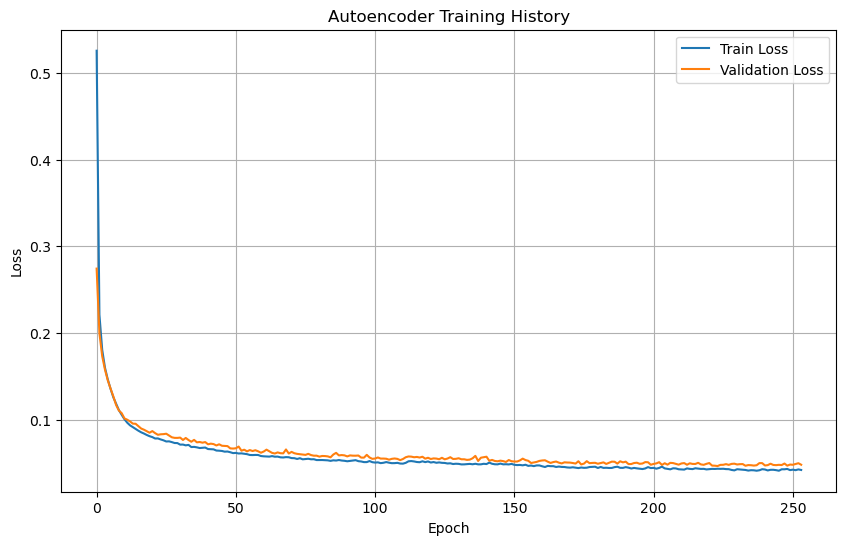


RECONSTRUCTION ERRORS
Mean reconstruction error ID: 0.046357
Mean reconstruction error OOD: 0.086120


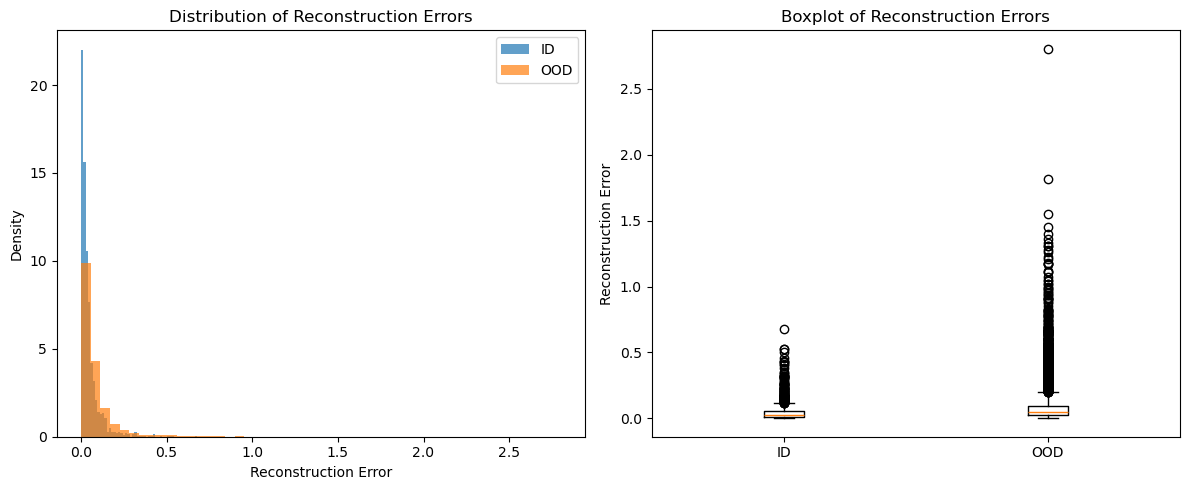


KS-TEST
statistic: 0.243100
p-value: 0.000000


In [8]:
# train AE, show test results
res = pipeline(
    ID_data,
    OOD_data
)

In [9]:
# Monte Carlo process for test ID and OOD data
# to prove that approach is correct and estimate True Positive Rate
monte_carlo(
    model=res[0], test_ID_dataset=res[1], test_OOD_dataset=res[2], device=res[3],
    num_experiments=10_000, sample_size=1_000, alpha=0.05,
    loader_batch_size=32
)

100%|██████████| 10000/10000 [02:00<00:00, 83.04it/s]


{'FPR': 0.0462,
 'FPR confint': (0.04225704225860869, 0.050491474662617365),
 'TPR': 1.0,
 'TPR confint': (0.9996160016293234, 1.0)}

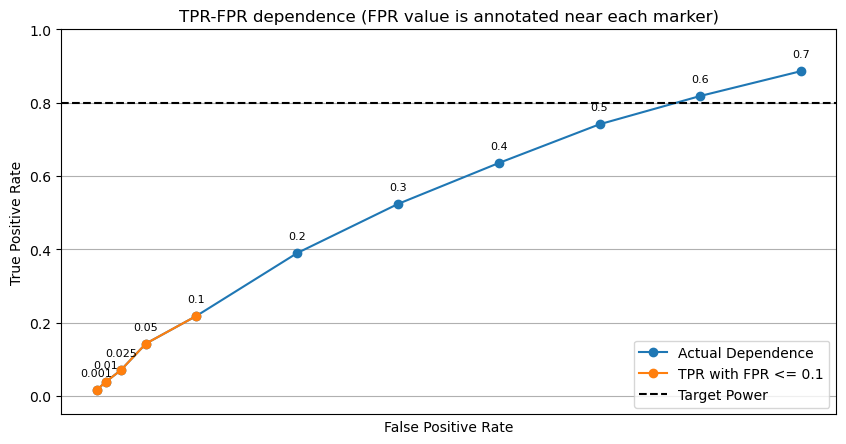

In [10]:
significance_levels = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

tpr_fpr = tpr_by_fpr(
    res[0], # model
    ID_data,
    OOD_data,
    significance_levels=significance_levels
)

plot_fpr_tpr(tpr_fpr[0], tpr_fpr[1])

100%|██████████| 5000/5000 [00:15<00:00, 320.59it/s]


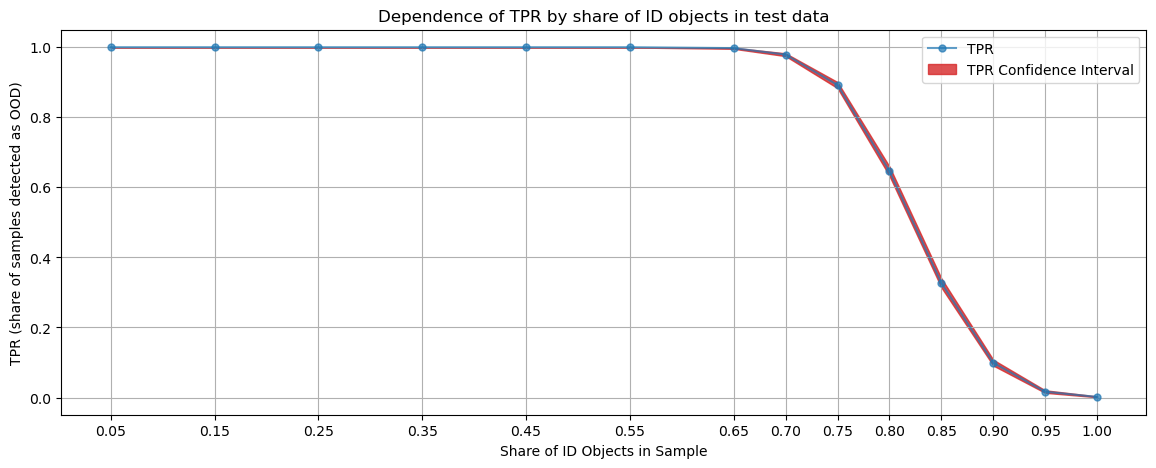

In [12]:
# dependence of TPR by share of ID objects in test data
# using Monte Carlo process again
mixture_levels, tp_data = tpr_on_mixtures(
    res,
    mixture_levels=np.concatenate((np.arange(0.05, 0.75, 0.1), np.arange(0.7, 1, 0.05))),
    N_experiments=5000,
    sample_size=1000,
    alpha=0.05
)

plot_tpr_mixtures(mixture_levels, tp_data)

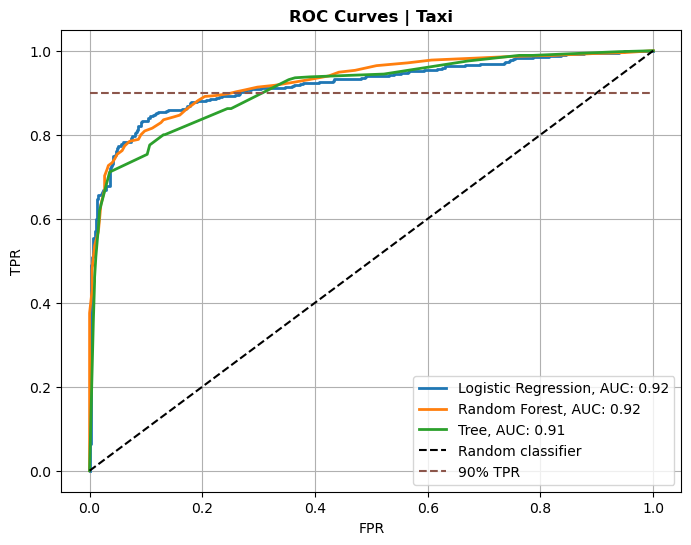

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.9190,0.8678,0.8858,0.8444,0.8646,0.3570
Random Forest,0.9249,0.8522,0.8644,0.8356,0.8497,0.4142
Decision Tree,0.9093,0.8344,0.8592,0.8000,0.8285,0.5099


In [13]:
# point-wise classification using distance 
# from "metric" list in start of the notebook
X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=1500, 
    ID_size=1500,
    test_size=0.3
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='Taxi',
    feature_names=metric,
    plot_roc=True
)

classification_results_df

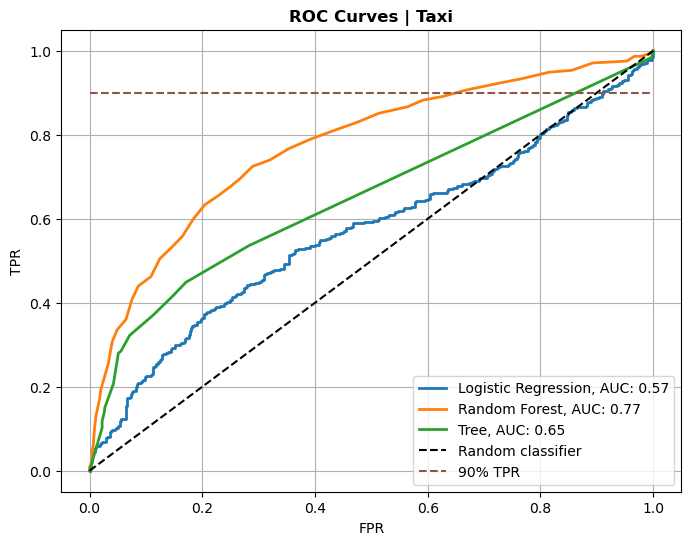

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.5705,0.5689,0.5724,0.5444,0.5581,0.6865
Random Forest,0.7728,0.7133,0.7297,0.6778,0.7028,0.6152
Decision Tree,0.6516,0.6389,0.7240,0.4489,0.5542,1.1631


In [14]:
# point-wise classification without distances
# only using a reconstruction error vector
X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=1500, 
    ID_size=1500,
    test_size=0.3,
    use_distance=False # use only reconstruction error vector
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='Taxi',
    feature_names=metric,
    plot_roc=True
)

classification_results_df

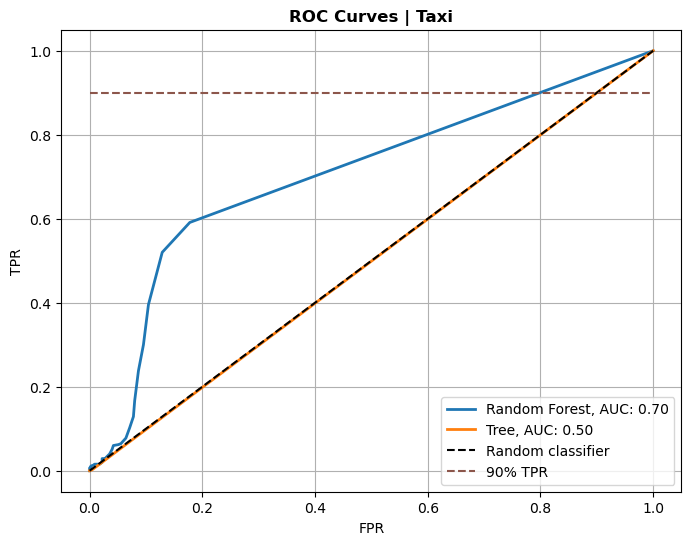

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Random Forest,0.7035,0.5044,0.8333,0.0111,0.0219,8.1545
Decision Tree,0.4989,0.4989,0.3333,0.0022,0.0044,17.9870


In [15]:
# train classification model on synthetic OOD data
# and test on real OOD data
X_train, X_test, y_train, y_test = classification_preprocess_synthetic(
    res,
    metrics=metric,
    OOD_size=1500,
    ID_size=1500,
    test_size=0.3,
    noise_mean=2.0,
    noise_std=1.0
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    ['forest', 'tree'], 
    save_tree_flg=False,
    dataset_name='Taxi',
    feature_names=metric,
    plot_roc=True
)

classification_results_df

### Electricity Data

In [30]:
ID_data = pd.read_csv('data/electricity_source.csv', usecols=['period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer'])
OOD_data = pd.read_csv('data/electricity_target.csv', usecols=['period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer'])

describe(ID_data, OOD_data)

ID data length:      9986
OOD data length:     10014
Number of features:  6
Numerical columns:   6
Categorical columns: 0


DATA VOLUME
Train: (6990, 6)
Validation: (1498, 6)
Test ID: (1498, 6)
Test OOD: (10014, 6)

TRAINING
Epoch 100/1000, Train Loss: 0.015658, Val Loss: 0.018825
Early stopping at epoch 129

LOSS FUNCTION


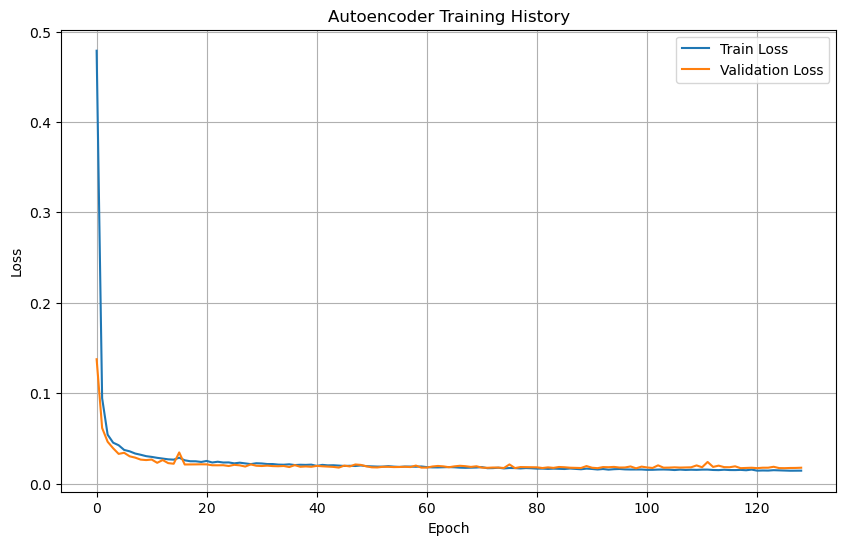


RECONSTRUCTION ERRORS
Mean reconstruction error ID: 0.019094
Mean reconstruction error OOD: 6.795331


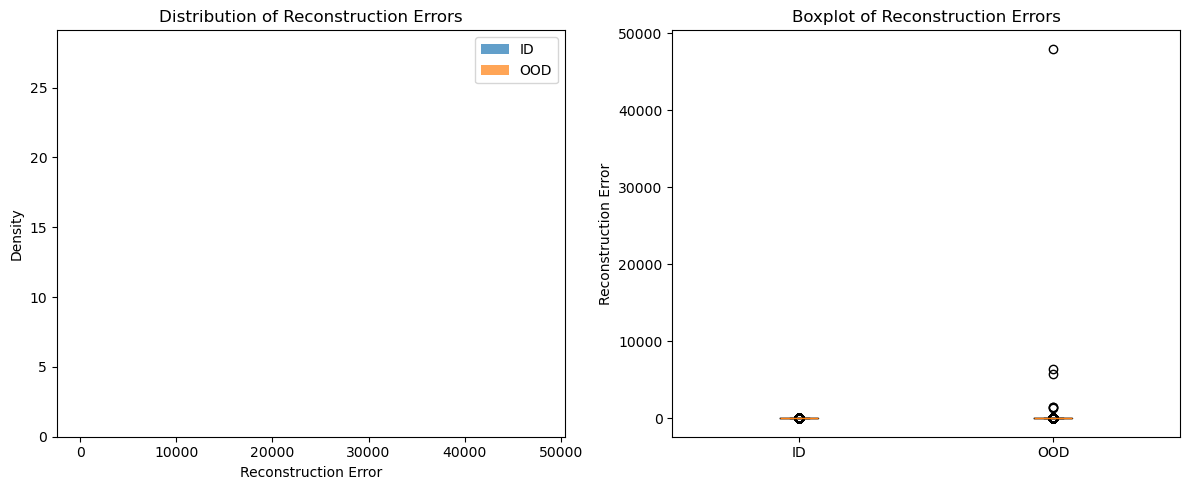


KS-TEST
statistic: 0.775460
p-value: 0.000000


In [9]:
res = pipeline(
    ID_data,
    OOD_data
)

In [8]:
monte_carlo(
    model=res[0], test_ID_dataset=res[1], test_OOD_dataset=res[2], device=res[3],
    num_experiments=10_000, sample_size=1_000, alpha=0.05,
    loader_batch_size=32
)

100%|██████████| 10000/10000 [02:00<00:00, 82.88it/s]


{'FPR': 0.0442,
 'FPR confint': (0.0403435047015169, 0.048406548213191875),
 'TPR': 1.0,
 'TPR confint': (0.9996160016293234, 1.0)}

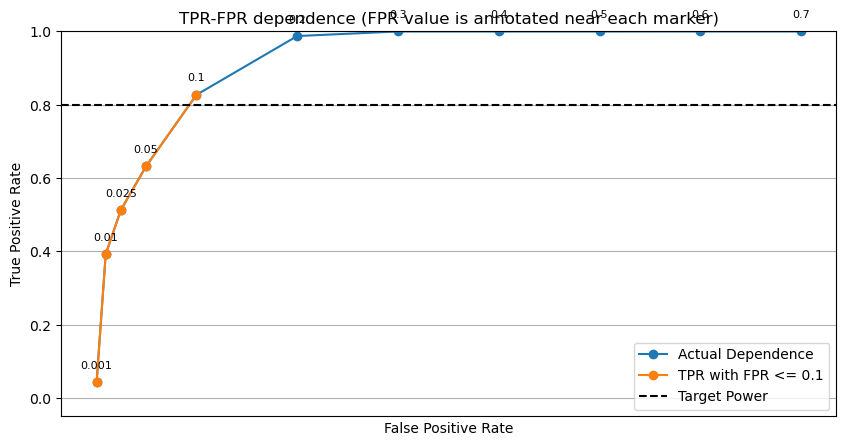

In [9]:
significance_levels = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

tpr_fpr = tpr_by_fpr(
    res[0], # model
    ID_data,
    OOD_data,
    significance_levels=significance_levels
)

plot_fpr_tpr(tpr_fpr[0], tpr_fpr[1])

100%|██████████| 5000/5000 [00:16<00:00, 301.14it/s]


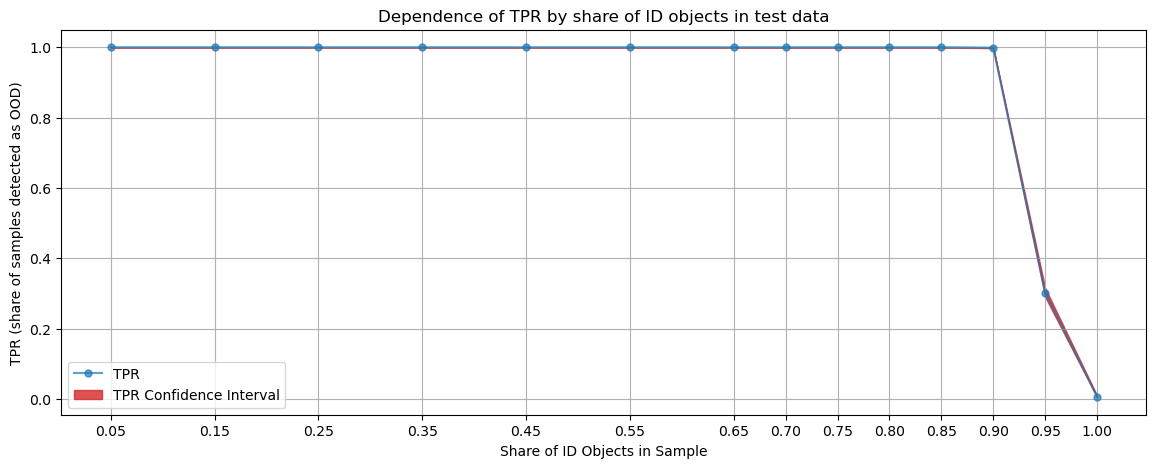

In [9]:
mixture_levels, tp_data = tpr_on_mixtures(
    res,
    mixture_levels=np.concatenate((np.arange(0.05, 0.75, 0.1), np.arange(0.7, 1, 0.05))),
    N_experiments=5000,
    sample_size=1000,
    alpha=0.05
)

plot_tpr_mixtures(mixture_levels, tp_data)

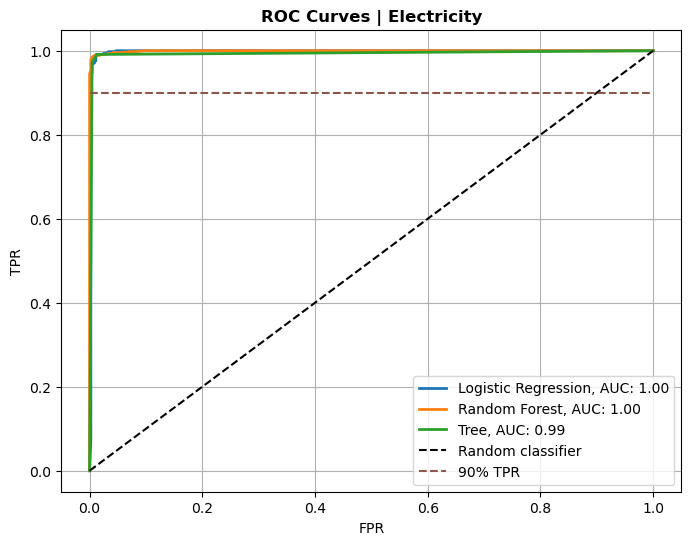

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.9974,0.9822,0.9909,0.9733,0.9820,0.0759
Random Forest,0.9993,0.9878,0.9867,0.9889,0.9878,0.0330
Decision Tree,0.9932,0.9889,0.9867,0.9911,0.9889,0.2491


In [ ]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=1498, 
    ID_size=len(res[1]),
    test_size=0.3
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='Electricity',
    plot_roc=True
)

classification_results_df

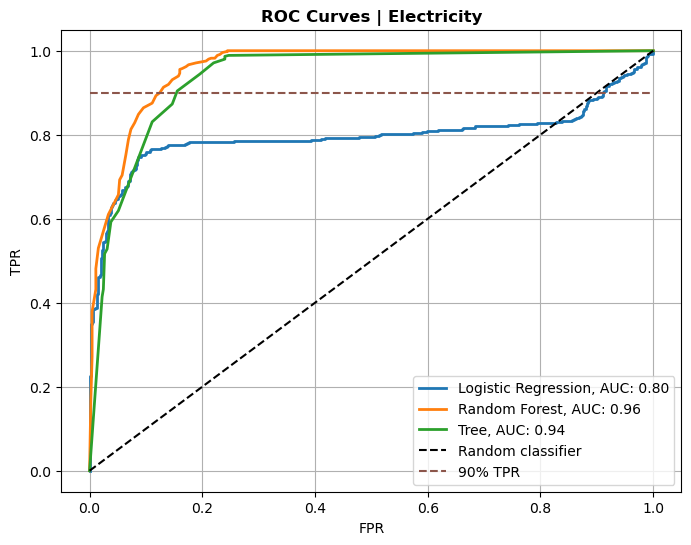

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.7965,0.8053,0.9202,0.6682,0.7742,0.5772
Random Forest,0.9584,0.8932,0.8551,0.9465,0.8985,0.2714
Decision Tree,0.9380,0.8743,0.8529,0.9042,0.8778,0.6483


In [10]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=1498, 
    ID_size=len(res[1]),
    test_size=0.3,
    use_distance=False
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='Electricity',
    plot_roc=True
)

classification_results_df

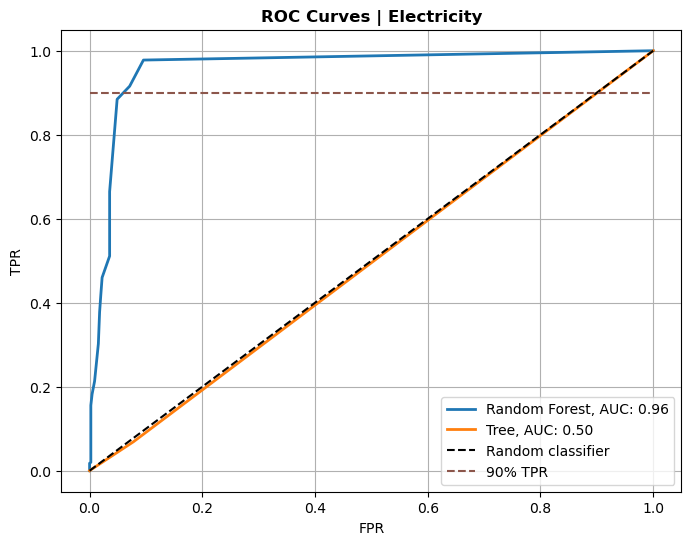

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Random Forest,0.9600,0.5056,1.0,0.0111,0.0220,1.5064
Decision Tree,0.4956,0.5000,0.5,0.0022,0.0044,16.8724


In [32]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess_synthetic(
    res, 
    metrics=metric, 
    OOD_size=1498, 
    ID_size=len(res[1]),
    test_size=0.3,
    noise_mean=0.0,
    noise_std=2.0
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    ['tree', 'forest'], 
    save_tree_flg=False, 
    dataset_name='Electricity',
    plot_roc=True
)

classification_results_df

### Income Data

In [39]:
ID_data = pd.read_csv('data/income_source.csv').reset_index()
ID_data = ID_data[ID_data.columns[2:-1]]

OOD_data = pd.read_csv('data/income_target.csv').reset_index()
OOD_data = OOD_data[OOD_data.columns[2:-1]]

describe(ID_data, OOD_data)

ID data length:      20380
OOD data length:     9782
Number of features:  12
Numerical columns:   0
Categorical columns: 12


DATA VOLUME
Train: (14266, 12)
Validation: (3057, 12)
Test ID: (3057, 12)
Test OOD: (9782, 12)

TRAINING
Epoch 100/1000, Train Loss: 0.119642, Val Loss: 0.128235
Epoch 200/1000, Train Loss: 0.100974, Val Loss: 0.113059
Early stopping at epoch 280

LOSS FUNCTION


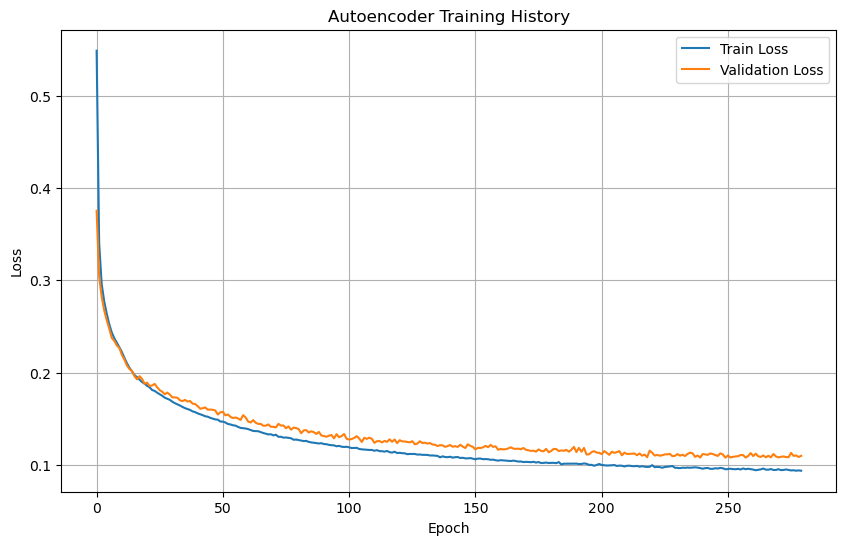


RECONSTRUCTION ERRORS
Mean reconstruction error ID: 0.108475
Mean reconstruction error OOD: 0.311518


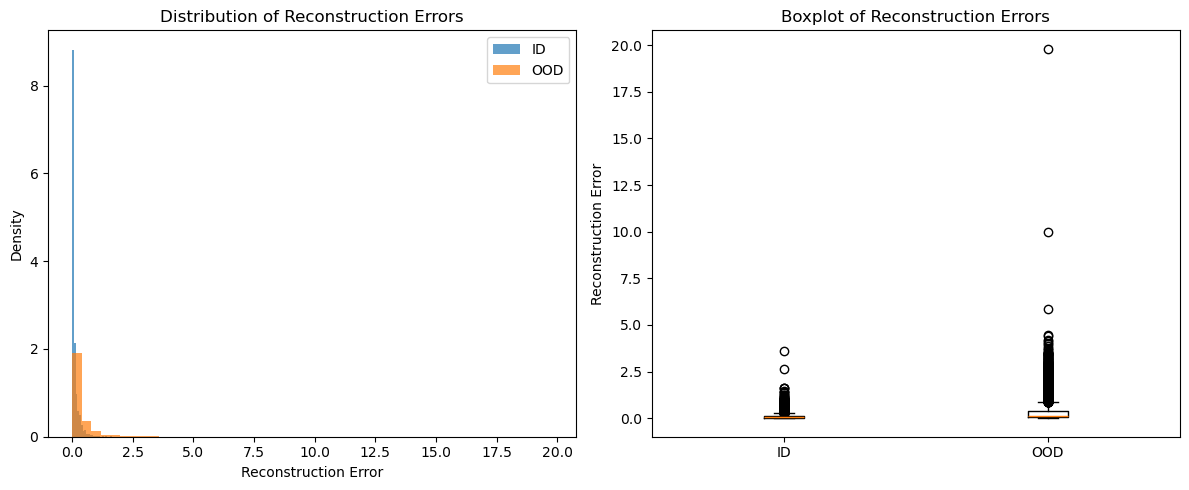


KS-TEST
statistic: 0.285334
p-value: 0.000000


In [40]:
res = pipeline(
    ID_data,
    OOD_data,
)

In [12]:
monte_carlo(
    model=res[0], test_ID_dataset=res[1], test_OOD_dataset=res[2], device=res[3],
    num_experiments=10_000, sample_size=1_000, alpha=0.05,
    loader_batch_size=32
)

100%|██████████| 10000/10000 [02:00<00:00, 83.02it/s]


{'FPR': 0.0474,
 'FPR confint': (0.04340618728991059, 0.051741408035225846),
 'TPR': 1.0,
 'TPR confint': (0.9996160016293234, 1.0)}

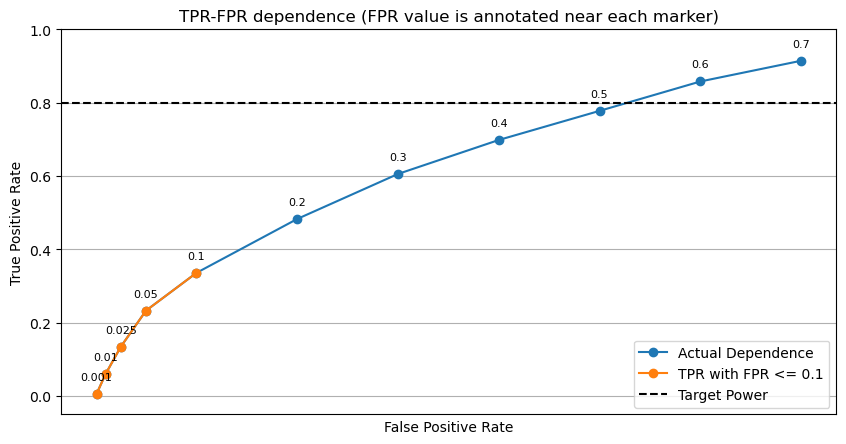

In [13]:
significance_levels = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

tpr_fpr = tpr_by_fpr(
    res[0], # model
    ID_data,
    OOD_data,
    significance_levels=significance_levels
)

plot_fpr_tpr(tpr_fpr[0], tpr_fpr[1])

100%|██████████| 5000/5000 [00:15<00:00, 325.95it/s]


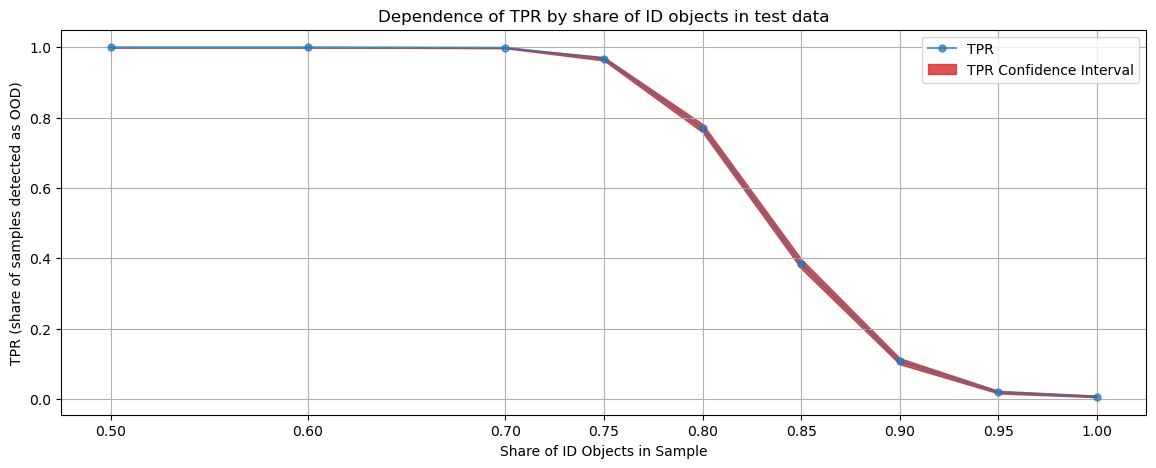

In [41]:
mixture_levels, tp_data = tpr_on_mixtures(
    res,
    mixture_levels=np.concatenate((np.arange(0.5, 0.7, 0.1), np.arange(0.7, 1, 0.05))),
    N_experiments=5000,
    sample_size=1000,
    alpha=0.05
)

plot_tpr_mixtures(mixture_levels, tp_data)

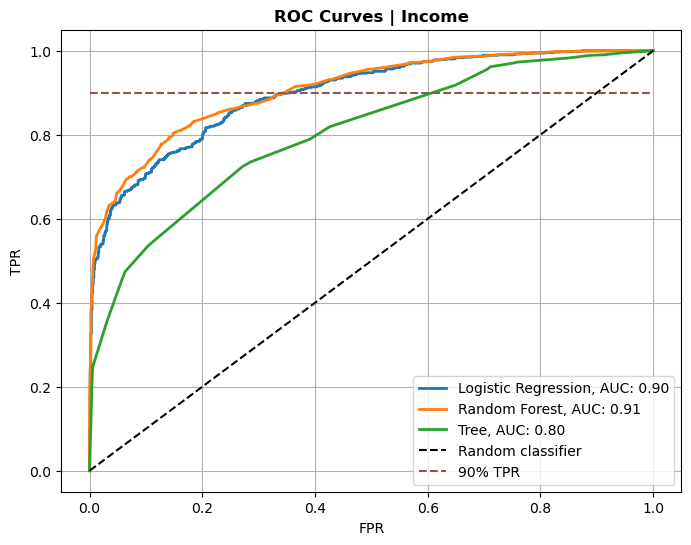

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.8972,0.8016,0.8264,0.7634,0.7937,0.3947
Random Forest,0.9069,0.8278,0.8442,0.8037,0.8235,0.3766
Decision Tree,0.8029,0.7264,0.7273,0.7241,0.7257,0.6867


In [ ]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=len(res[1]), 
    ID_size=len(res[1]),
    test_size=0.3
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='Income',
    plot_roc=True
)

classification_results_df

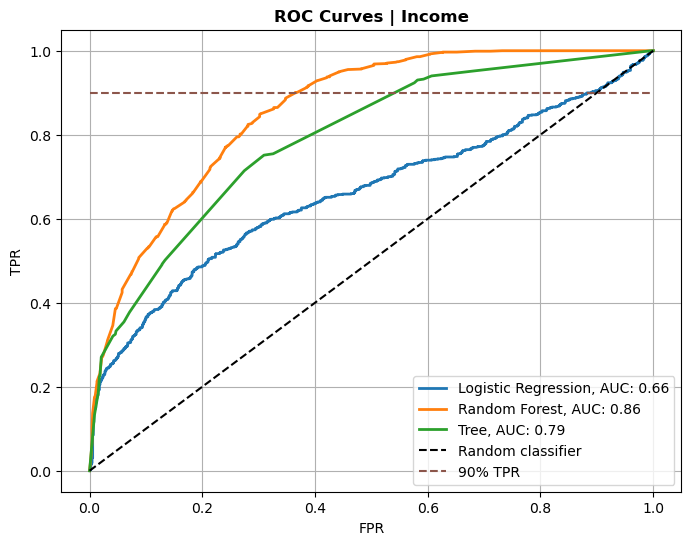

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.6601,0.6447,0.7035,0.4995,0.5842,0.6414
Random Forest,0.8557,0.7662,0.7485,0.8015,0.7741,0.4941
Decision Tree,0.7905,0.7210,0.7081,0.7514,0.7291,0.6884


In [13]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=len(res[1]), 
    ID_size=len(res[1]),
    test_size=0.3,
    use_distance=False
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='Income',
    plot_roc=True
)

classification_results_df

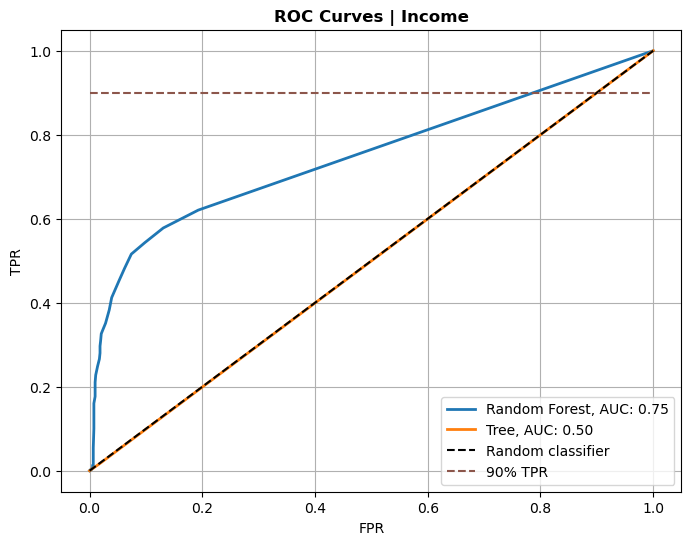

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Random Forest,0.7485,0.5041,0.7059,0.0131,0.0257,7.386
Decision Tree,0.4995,0.4997,0.4857,0.0185,0.0357,17.697


In [49]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess_synthetic(
    res, 
    metrics=metric, 
    OOD_size=len(res[1]), 
    ID_size=len(res[1]),
    test_size=0.3,
    noise_mean=1.0,
    noise_std=1.0
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    ['forest', 'tree'], 
    save_tree_flg=False, 
    dataset_name='Income',
    plot_roc=True
)

classification_results_df

### MV x6 Data

In [33]:
ID_data = pd.read_csv('data/mv_x6_source.csv', usecols=['x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10'])
OOD_data = pd.read_csv('data/mv_x6_target.csv', usecols=['x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10'])

describe(ID_data, OOD_data)

ID data length:      20384
OOD data length:     20384
Number of features:  9
Numerical columns:   6
Categorical columns: 3


DATA VOLUME
Train: (14268, 9)
Validation: (3058, 9)
Test ID: (3058, 9)
Test OOD: (20384, 9)

TRAINING
Epoch 100/1000, Train Loss: 0.082070, Val Loss: 0.082706
Epoch 200/1000, Train Loss: 0.072244, Val Loss: 0.076167
Epoch 300/1000, Train Loss: 0.062028, Val Loss: 0.062806
Early stopping at epoch 378

LOSS FUNCTION


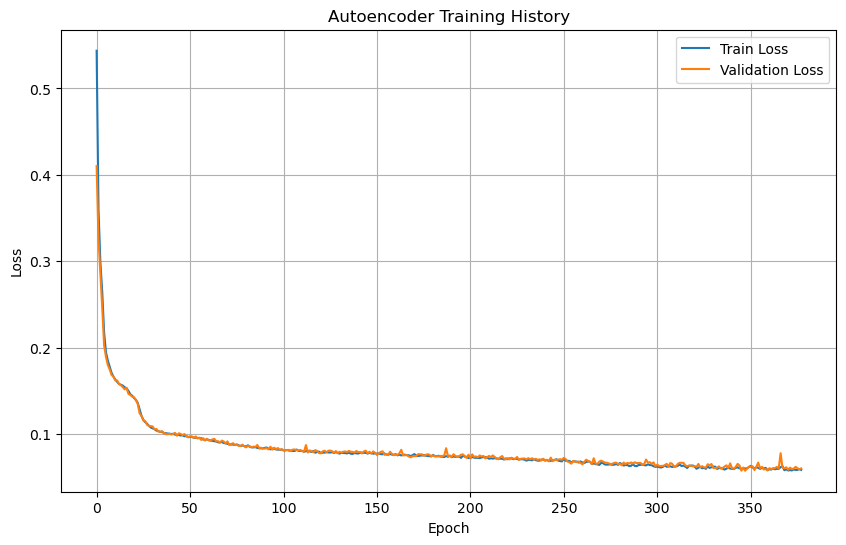


RECONSTRUCTION ERRORS
Mean reconstruction error ID: 0.063726
Mean reconstruction error OOD: 2.949870


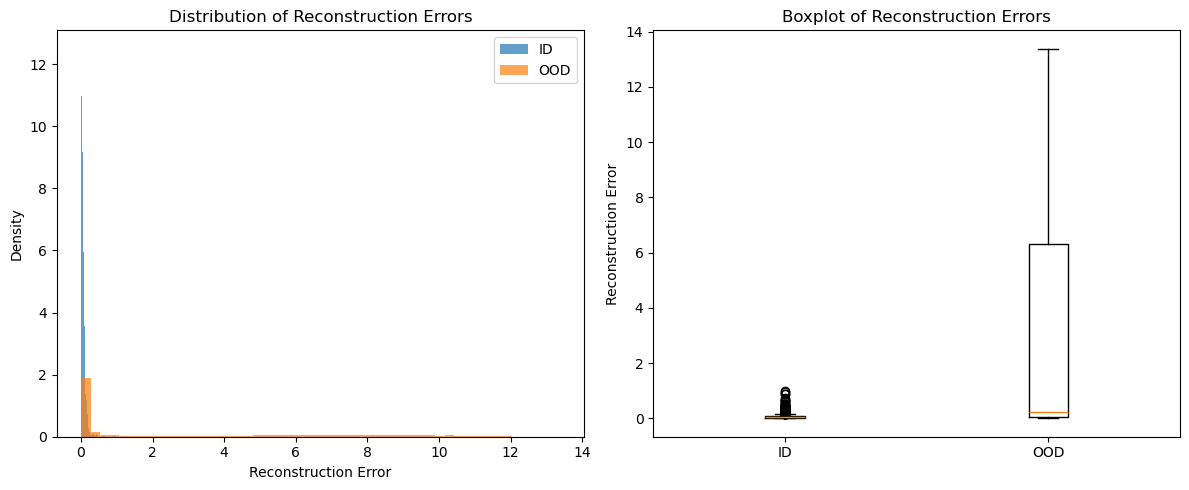


KS-TEST
statistic: 0.479270
p-value: 0.000000


In [51]:
res = pipeline(ID_data, OOD_data)

In [16]:
monte_carlo(
    model=res[0], test_ID_dataset=res[1], test_OOD_dataset=res[2], device=res[3],
    num_experiments=10_000, sample_size=1_000, alpha=0.05,
    loader_batch_size=32
)

100%|██████████| 10000/10000 [02:00<00:00, 83.32it/s]


{'FPR': 0.0496,
 'FPR confint': (0.04551483891184551, 0.054031066820459946),
 'TPR': 1.0,
 'TPR confint': (0.9996160016293234, 1.0)}

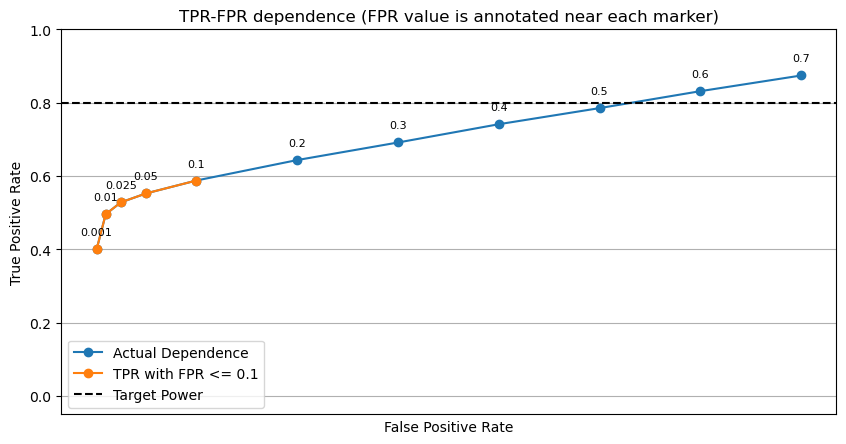

In [44]:
significance_levels = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

tpr_fpr = tpr_by_fpr(
    res[0], # model
    ID_data,
    OOD_data,
    significance_levels=significance_levels
)

plot_fpr_tpr(tpr_fpr[0], tpr_fpr[1])

100%|██████████| 5000/5000 [00:17<00:00, 278.37it/s]


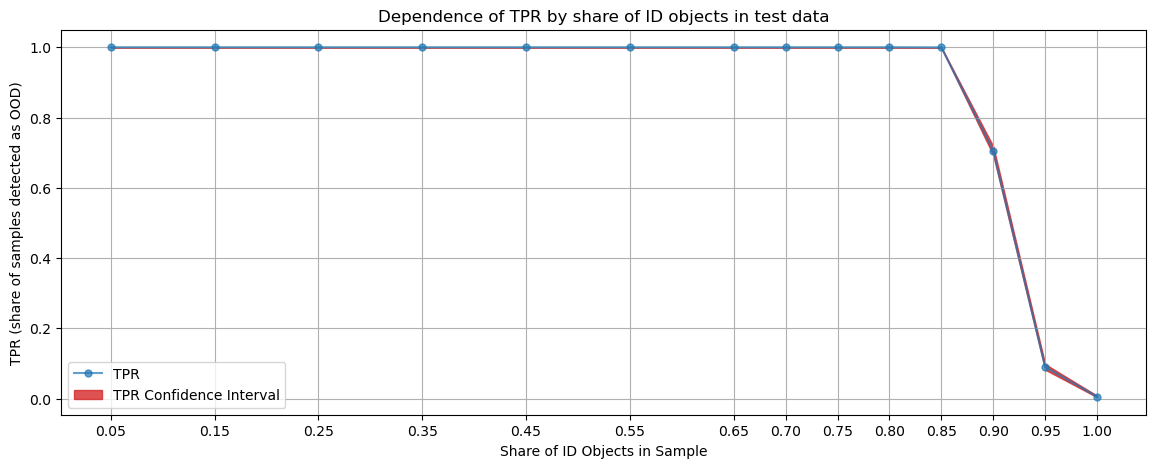

In [15]:
mixture_levels, tp_data = tpr_on_mixtures(
    res,
    mixture_levels=np.concatenate((np.arange(0.05, 0.75, 0.1), np.arange(0.7, 1, 0.05))),
    N_experiments=5000,
    sample_size=1000,
    alpha=0.05
)

plot_tpr_mixtures(mixture_levels, tp_data)

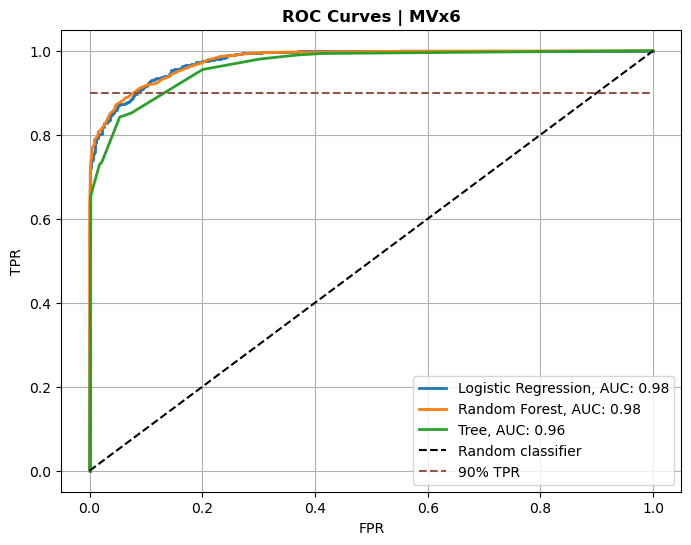

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.9784,0.9084,0.9147,0.9008,0.9077,0.1842
Random Forest,0.9779,0.9106,0.9283,0.8899,0.9087,0.2013
Decision Tree,0.9640,0.8888,0.9199,0.8517,0.8845,0.3645


In [ ]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=len(res[1]), 
    ID_size=len(res[1]),
    test_size=0.3
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='MVx6',
    plot_roc=True
)

classification_results_df

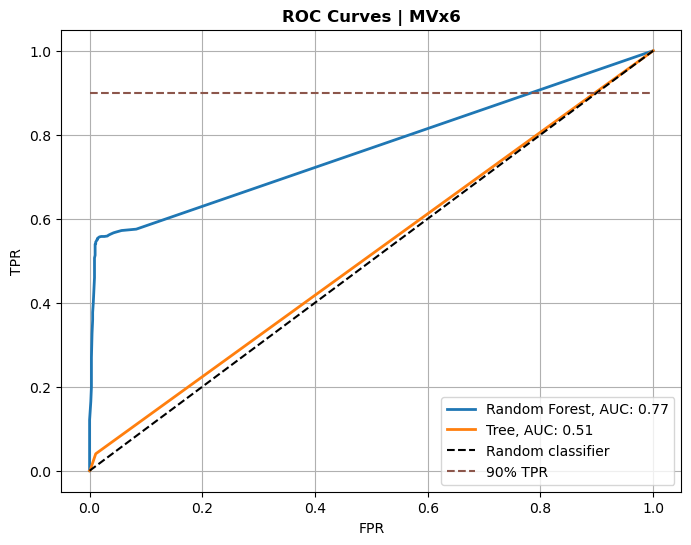

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Random Forest,0.7668,0.6612,0.9868,0.3268,0.4910,7.8793
Decision Tree,0.5147,0.5147,0.7872,0.0403,0.0767,17.3301


In [60]:
ID_size = len(res[1])

X_train, X_test, y_train, y_test = classification_preprocess_synthetic(
    res, 
    metrics=metric, 
    OOD_size=len(res[1]), 
    ID_size=len(res[1]),
    test_size=0.3,
    noise_mean=2.0,
    noise_std=5.0
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    ['forest', 'tree'], 
    save_tree_flg=False, 
    dataset_name='MVx6',
    plot_roc=True
)

classification_results_df

### Diabetes Data

In [35]:
ID_data = pd.read_csv('data/diabites_source.csv')
ID_data = ID_data[ID_data.columns[:-1]]

OOD_data = pd.read_csv('data/diabites_target.csv').iloc[:1500]
OOD_data = OOD_data[OOD_data.columns[:-1]]

describe(ID_data, OOD_data)

ID data length:      34288
OOD data length:     1500
Number of features:  183
Numerical columns:   10
Categorical columns: 173


In [20]:
print('ID data length:     ', len(ID_data))
print('OOD data length:    ', len(OOD_data))
print('Number of features: ', len(ID_data.columns))

ID data length:      34288
OOD data length:     1500
Number of features:  183


DATA VOLUME
Train: (24001, 183)
Validation: (5143, 183)
Test ID: (5144, 183)
Test OOD: (1500, 183)

TRAINING
Epoch 100/1000, Train Loss: 0.511293, Val Loss: 0.556104
Epoch 200/1000, Train Loss: 0.478417, Val Loss: 0.493044
Epoch 300/1000, Train Loss: 0.475503, Val Loss: 0.488724
Early stopping at epoch 342

LOSS FUNCTION


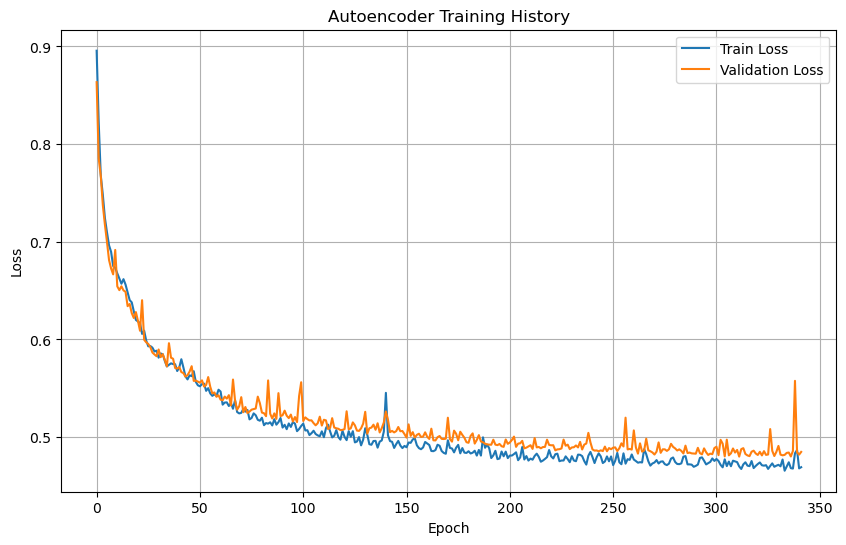


RECONSTRUCTION ERRORS
Mean reconstruction error ID: 0.467079
Mean reconstruction error OOD: 0.580671


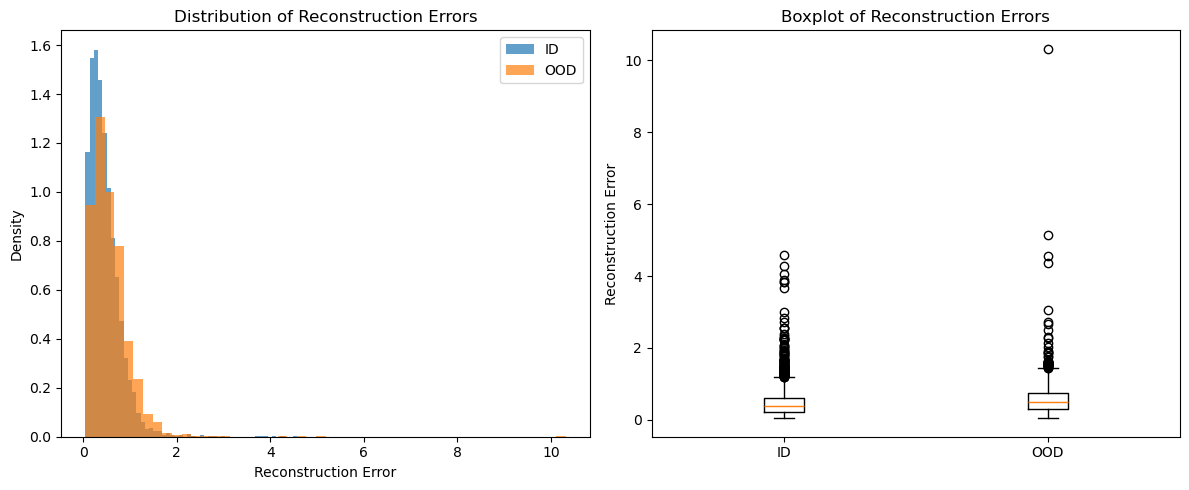


KS-TEST
statistic: 0.140842
p-value: 0.000000


In [62]:
res = pipeline(
    ID_data,
    OOD_data,
    latent_dim=20,
    hidden_dims=[64,64,64,32]
)

In [20]:
monte_carlo(
    model=res[0], test_ID_dataset=res[1], test_OOD_dataset=res[2], device=res[3],
    num_experiments=10_000, sample_size=1_000, alpha=0.05,
    loader_batch_size=32
)

100%|██████████| 10000/10000 [02:48<00:00, 59.49it/s]


{'FPR': 0.0462,
 'FPR confint': (0.04225704225860869, 0.050491474662617365),
 'TPR': 1.0,
 'TPR confint': (0.9996160016293234, 1.0)}

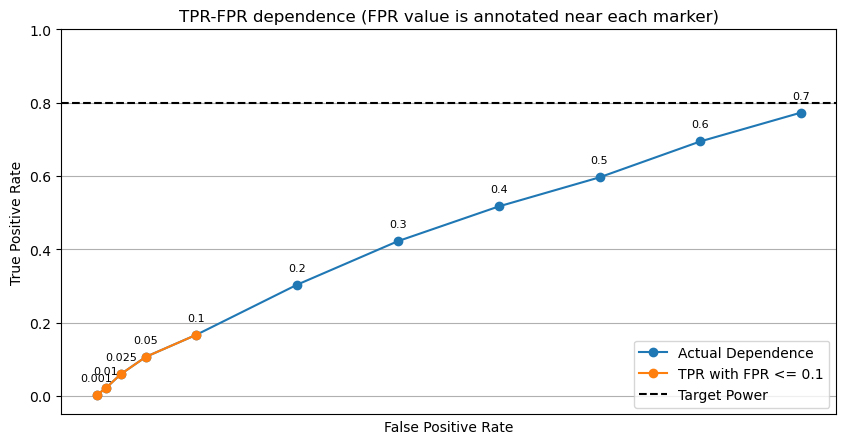

In [48]:
significance_levels = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

tpr_fpr = tpr_by_fpr(
    res[0], # model
    ID_data,
    OOD_data,
    significance_levels=significance_levels
)

plot_fpr_tpr(tpr_fpr[0], tpr_fpr[1])

100%|██████████| 5000/5000 [00:24<00:00, 202.99it/s]


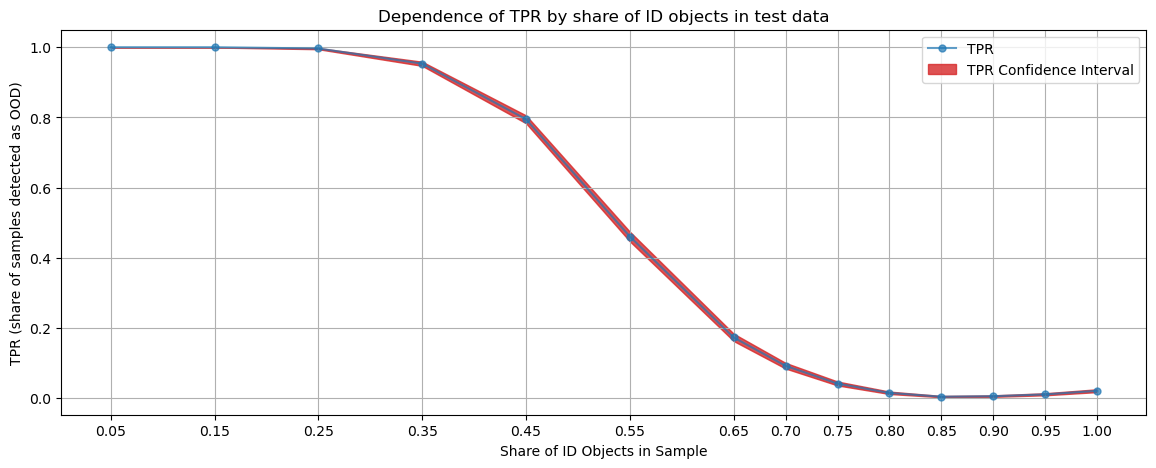

In [18]:
mixture_levels, tp_data = tpr_on_mixtures(
    res,
    mixture_levels=np.concatenate((np.arange(0.05, 0.75, 0.1), np.arange(0.7, 1, 0.05))),
    N_experiments=5000,
    sample_size=1000,
    alpha=0.05
)

plot_tpr_mixtures(mixture_levels, tp_data)

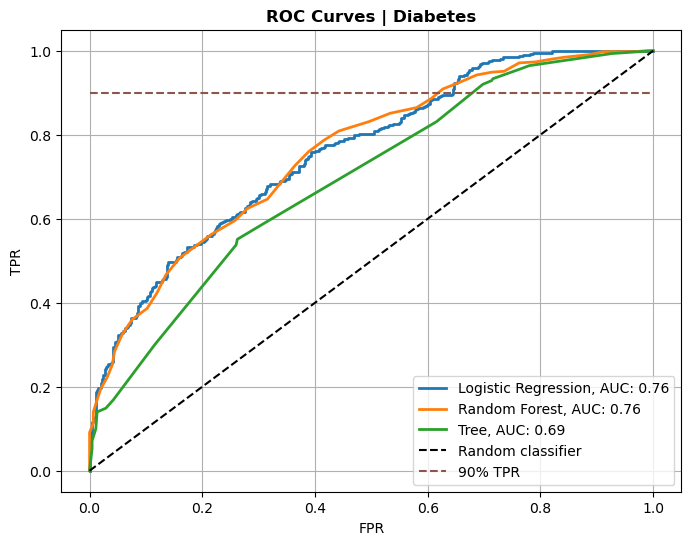

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.7603,0.6756,0.6660,0.7044,0.6847,0.5675
Random Forest,0.7580,0.6733,0.6688,0.6867,0.6776,0.5764
Decision Tree,0.6947,0.6389,0.6521,0.5956,0.6225,0.8087


In [ ]:
size = min(len(res[1]), len(res[2]))

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=size, 
    ID_size=size,
    test_size=0.3
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='Diabetes',
    plot_roc=True
)

classification_results_df

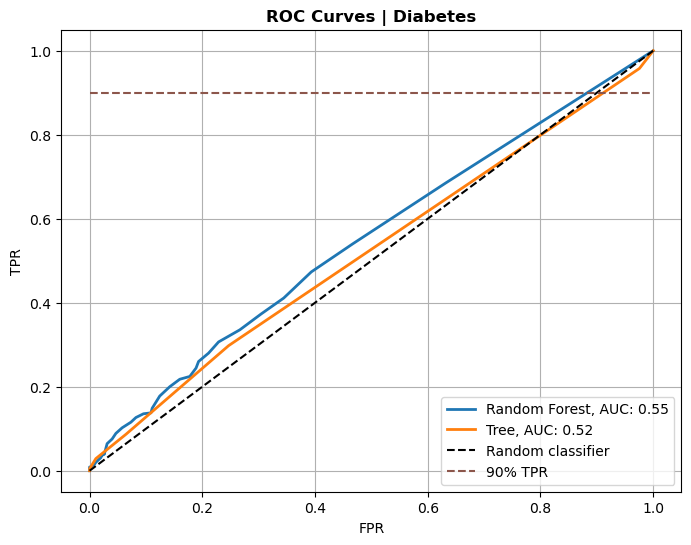

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Random Forest,0.5480,0.5067,0.6000,0.0400,0.0750,6.5282
Decision Tree,0.5198,0.5111,0.5735,0.0867,0.1506,1.6512


In [67]:
size = min(len(res[1]), len(res[2]))

X_train, X_test, y_train, y_test = classification_preprocess_synthetic(
    res, 
    metrics=metric, 
    OOD_size=size, 
    ID_size=size,
    test_size=0.3,
    noise_mean=0.0,
    noise_std=1.0
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    ['forest', 'tree'], 
    save_tree_flg=False, 
    dataset_name='Diabetes',
    plot_roc=True
)

classification_results_df

### California Data

In [37]:
ID_data = pd.read_csv('data/california_source.csv')
ID_data = ID_data[ID_data.columns[1:-1]]

OOD_data = pd.read_csv('data/california_target.csv')
OOD_data = OOD_data[OOD_data.columns[1:-1]]

describe(ID_data, OOD_data)

ID data length:      10315
OOD data length:     10319
Number of features:  7
Numerical columns:   6
Categorical columns: 1


DATA VOLUME
Train: (5157, 7)
Validation: (2579, 7)
Test ID: (2579, 7)
Test OOD: (10319, 7)

TRAINING
Epoch 100/1000, Train Loss: 0.034914, Val Loss: 0.032904
Epoch 200/1000, Train Loss: 0.028220, Val Loss: 0.029697
Epoch 300/1000, Train Loss: 0.026647, Val Loss: 0.027654
Early stopping at epoch 308

LOSS FUNCTION


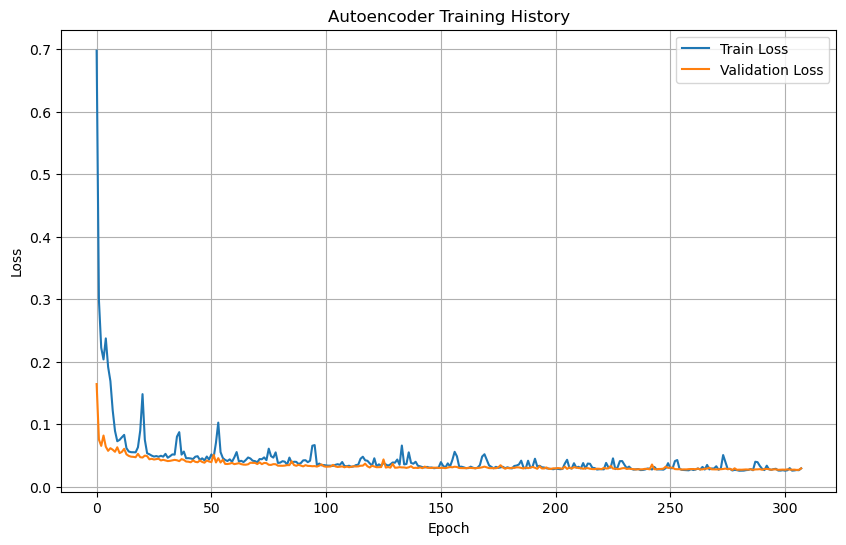


RECONSTRUCTION ERRORS
Mean reconstruction error ID: 0.046669
Mean reconstruction error OOD: 0.104839


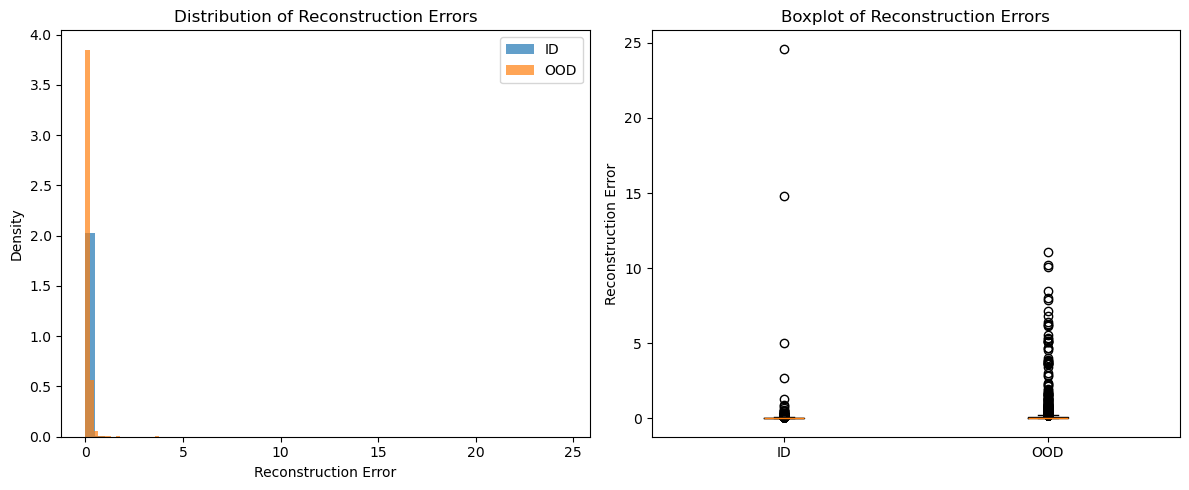


KS-TEST
statistic: 0.275385
p-value: 0.000000


In [69]:
res = pipeline(ID_data, OOD_data, test_size=0.5)

In [24]:
monte_carlo(
    model=res[0], test_ID_dataset=res[1], test_OOD_dataset=res[2], device=res[3],
    num_experiments=10_000, sample_size=1_000, alpha=0.05,
    loader_batch_size=32
)

100%|██████████| 10000/10000 [02:01<00:00, 82.54it/s]


{'FPR': 0.0452,
 'FPR confint': (0.041300001086809354, 0.049449283831158056),
 'TPR': 1.0,
 'TPR confint': (0.9996160016293234, 1.0)}

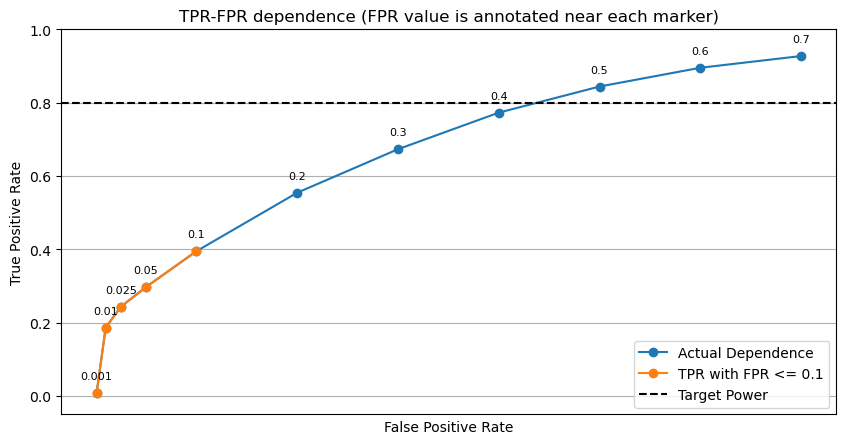

In [25]:
significance_levels = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

tpr_fpr = tpr_by_fpr(
    res[0], # model
    ID_data,
    OOD_data,
    significance_levels=significance_levels
)

plot_fpr_tpr(tpr_fpr[0], tpr_fpr[1])

100%|██████████| 5000/5000 [00:16<00:00, 304.10it/s]


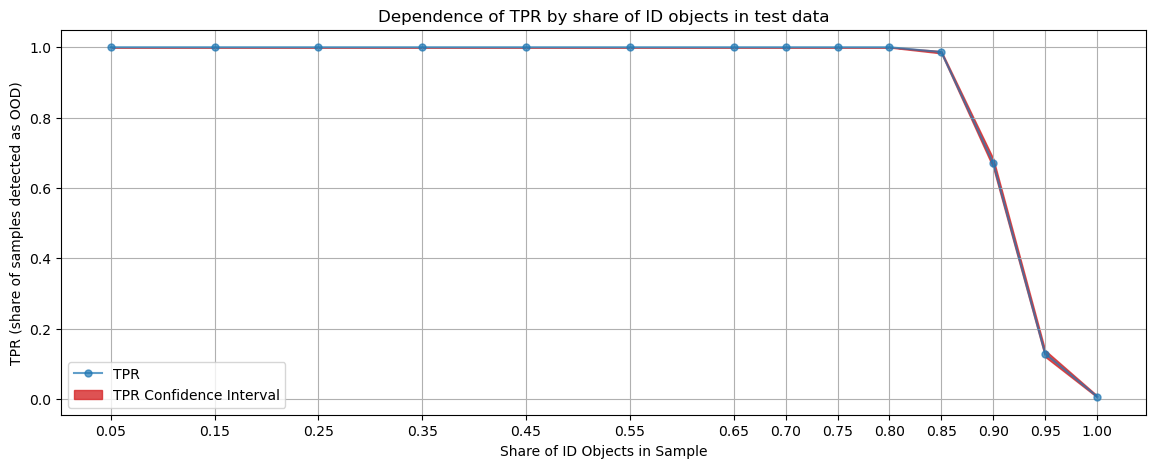

In [21]:
mixture_levels, tp_data = tpr_on_mixtures(
    res,
    mixture_levels=np.concatenate((np.arange(0.05, 0.75, 0.1), np.arange(0.7, 1, 0.05))),
    N_experiments=5000,
    sample_size=1000,
    alpha=0.05
)

plot_tpr_mixtures(mixture_levels, tp_data)

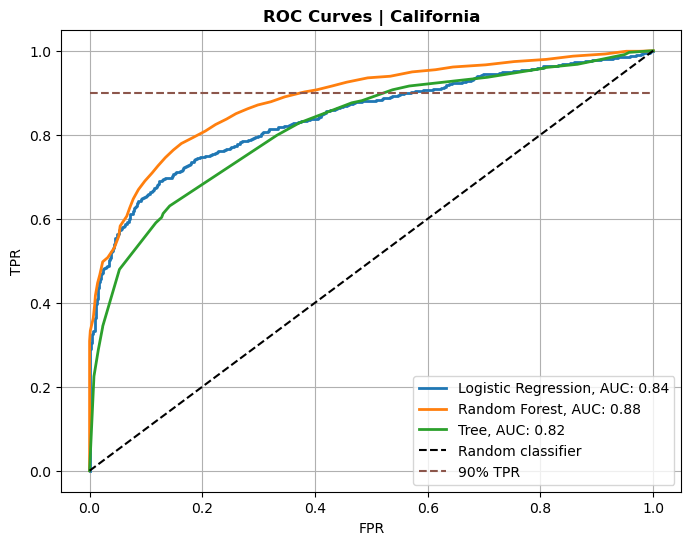

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.8413,0.7758,0.8154,0.7132,0.7609,0.4837
Random Forest,0.8824,0.8081,0.8272,0.7791,0.8024,0.4462
Decision Tree,0.8194,0.7442,0.8161,0.6305,0.7114,0.7071


In [ ]:
size = min(len(res[1]), len(res[2]))

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=size, 
    ID_size=size,
    test_size=0.3
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='California',
    plot_roc=True
)

classification_results_df

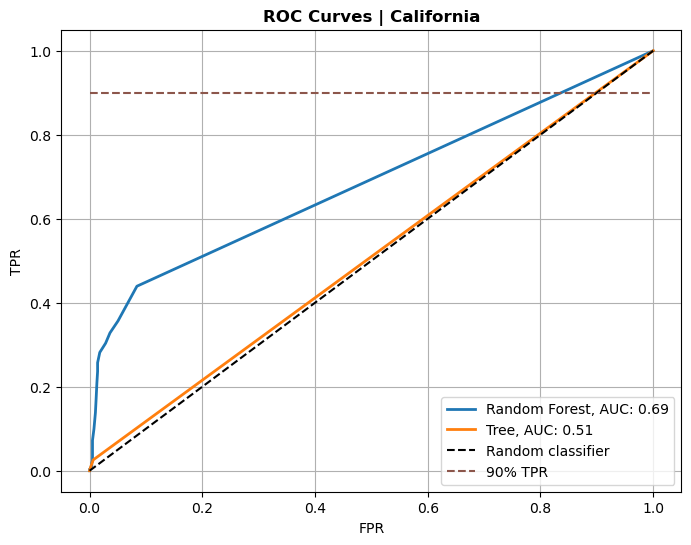

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Random Forest,0.6853,0.5019,1.0,0.0039,0.0077,10.6165
Decision Tree,0.5097,0.5006,1.0,0.0013,0.0026,17.5699


In [73]:
size = min(len(res[1]), len(res[2]))

X_train, X_test, y_train, y_test = classification_preprocess_synthetic(
    res, 
    metrics=metric, 
    OOD_size=size, 
    ID_size=size,
    test_size=0.3,
    noise_mean=0.0,
    noise_std=1.5
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    ['tree', 'forest'], 
    save_tree_flg=False, 
    dataset_name='California',
    plot_roc=True
)

classification_results_df

### ACS Accidents Data

In [38]:
ID_data = pd.read_csv('data/acs_accidents_source.csv')
ID_data = ID_data[ID_data.columns[1:-1]]

OOD_data = pd.read_csv('data/acs_accidents_target.csv')
OOD_data = OOD_data[OOD_data.columns[1:-1]]

describe(ID_data, OOD_data)

ID data length:      22653
OOD data length:     3955
Number of features:  45
Numerical columns:   45
Categorical columns: 0


DATA VOLUME
Train: (11326, 45)
Validation: (5663, 45)
Test ID: (5664, 45)
Test OOD: (3955, 45)

TRAINING
Epoch 100/1000, Train Loss: 0.262512, Val Loss: 0.305486
Epoch 200/1000, Train Loss: 0.243615, Val Loss: 0.285607
Epoch 300/1000, Train Loss: 0.234435, Val Loss: 0.279520
Early stopping at epoch 363

LOSS FUNCTION


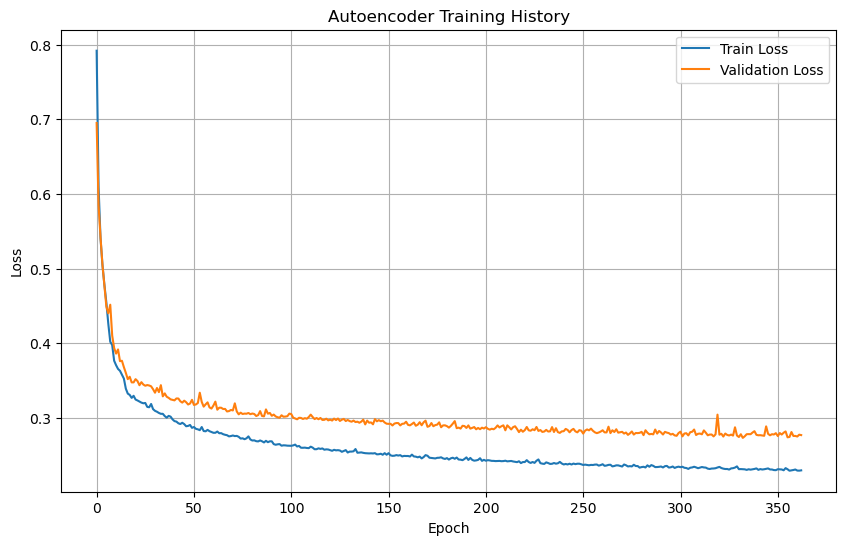


RECONSTRUCTION ERRORS
Mean reconstruction error ID: 0.267274
Mean reconstruction error OOD: 0.728736


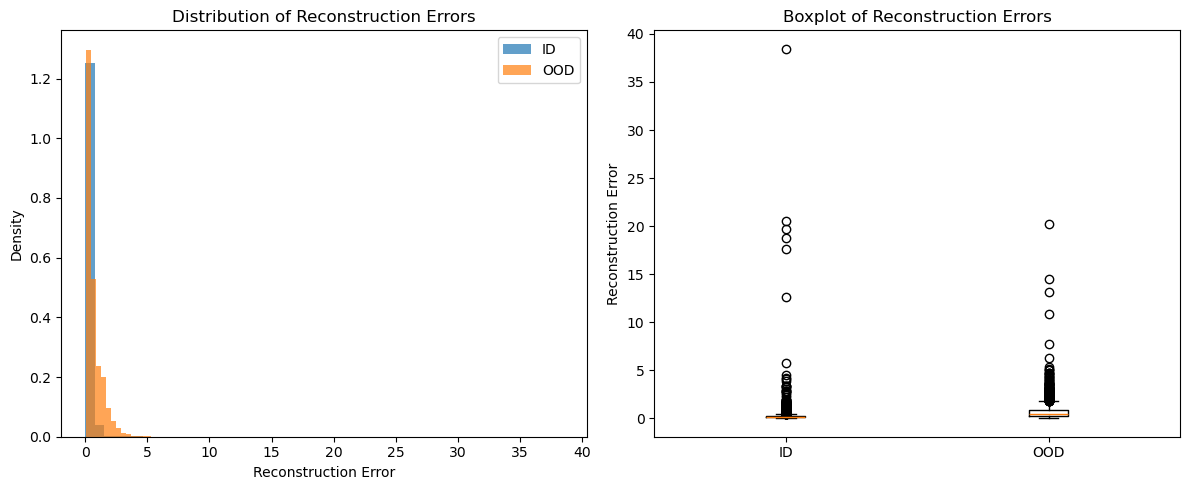


KS-TEST
statistic: 0.556855
p-value: 0.000000


In [75]:
res = pipeline(ID_data, OOD_data, test_size=0.5)

In [28]:
monte_carlo(
    model=res[0], test_ID_dataset=res[1], test_OOD_dataset=res[2], device=res[3],
    num_experiments=10_000, sample_size=1_000, alpha=0.05,
    loader_batch_size=32
)

100%|██████████| 10000/10000 [01:57<00:00, 84.81it/s]


{'FPR': 0.0496,
 'FPR confint': (0.04551483891184551, 0.054031066820459946),
 'TPR': 1.0,
 'TPR confint': (0.9996160016293234, 1.0)}

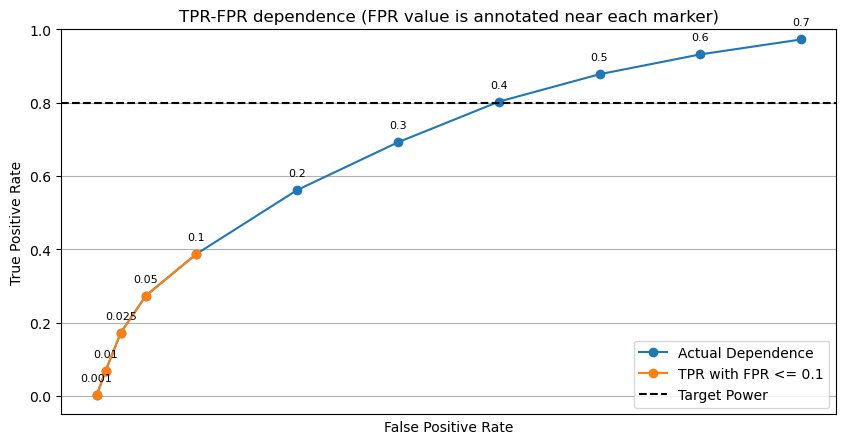

In [29]:
significance_levels = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

tpr_fpr = tpr_by_fpr(
    res[0], # model
    ID_data,
    OOD_data,
    significance_levels=significance_levels
)

plot_fpr_tpr(tpr_fpr[0], tpr_fpr[1])

100%|██████████| 5000/5000 [00:16<00:00, 299.99it/s]


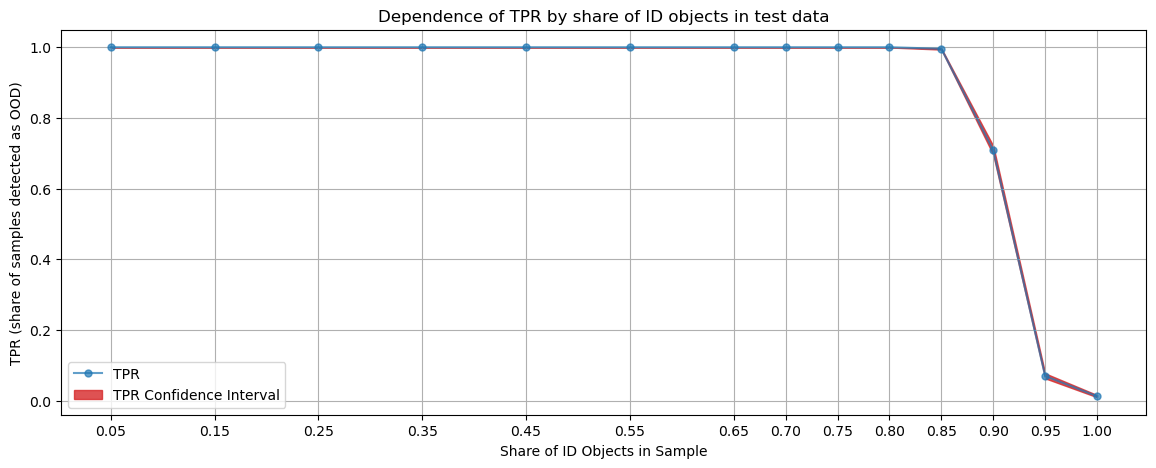

In [24]:
mixture_levels, tp_data = tpr_on_mixtures(
    res,
    mixture_levels=np.concatenate((np.arange(0.05, 0.75, 0.1), np.arange(0.7, 1, 0.05))),
    N_experiments=5000,
    sample_size=1000,
    alpha=0.05
)

plot_tpr_mixtures(mixture_levels, tp_data)

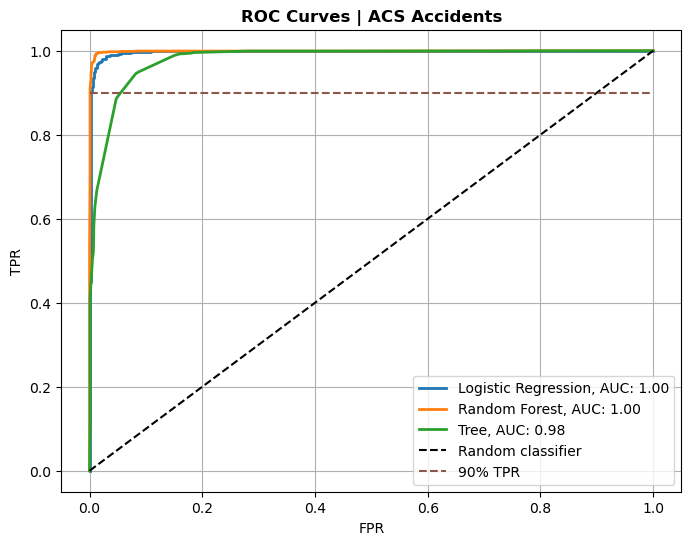

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Logistic Regression,0.9963,0.9772,0.9805,0.9739,0.9772,0.0768
Random Forest,0.9986,0.9899,0.9891,0.9907,0.9899,0.0731
Decision Tree,0.9801,0.9313,0.9162,0.9494,0.9325,0.1925


In [ ]:
size = min(len(res[1]), len(res[2]))

X_train, X_test, y_train, y_test = classification_preprocess(
    res, 
    metrics=metric, 
    OOD_size=size, 
    ID_size=size,
    test_size=0.3
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    models, 
    save_tree_flg=False, 
    dataset_name='ACS Accidents',
    plot_roc=True
)

classification_results_df

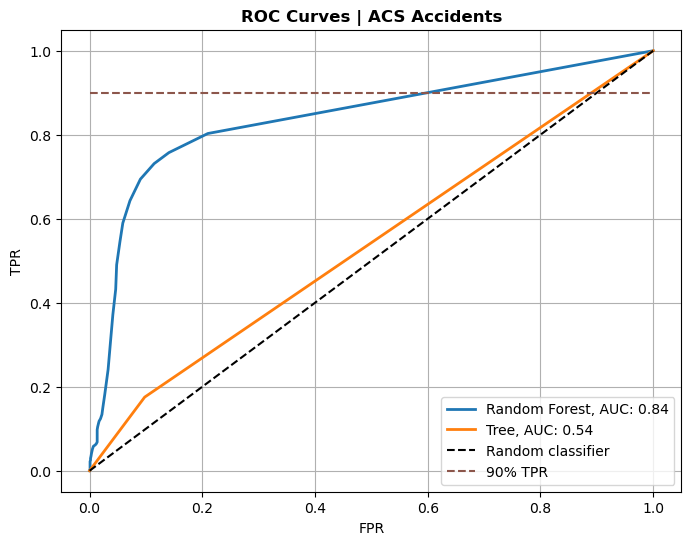

,roc-auc,accuracy,precision,recall,f1-score,log-loss
Random Forest,0.8383,0.5257,0.8588,0.0615,0.1148,4.3077
Decision Tree,0.5388,0.5388,0.6420,0.1752,0.2753,14.9532


In [76]:
size = min(len(res[1]), len(res[2]))

X_train, X_test, y_train, y_test = classification_preprocess_synthetic(
    res, 
    metrics=metric, 
    OOD_size=size, 
    ID_size=size,
    test_size=0.3,
    noise_mean=0.0,
    noise_std=1.0
)

classification_results_df = train_models(
    X_train, X_test, y_train, y_test, 
    ['forest', 'tree'], 
    save_tree_flg=False, 
    dataset_name='ACS Accidents',
    plot_roc=True
)

classification_results_df